In [2]:
import numpy as np, scipy.linalg as linlg
import matplotlib.pyplot as plt
from   IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
import pprint
import datetime
import matplotlib.dates as md
from pathlib import Path
import os
import math
import warnings
from scipy.integrate import solve_ivp
import scipy
import statsmodels.api as sm
from IPython.display import clear_output
from scipy.interpolate import interpn
import matplotlib.lines as lines

display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)
import matplotlib.ticker as mtick
fmt = '${x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
tick2 = mtick.StrMethodFormatter('${x:,.0f}')
normal = mtick.StrMethodFormatter('{x:,.0f}')
normal2 = mtick.StrMethodFormatter('{x:,.2f}')

In [4]:
colors       = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 8, 'color': colors['grey'], 'labelcolor': colors['grey'], "labelsize":8}
config_title = {'size': 8, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}
#myFmt        = DateFormatter("%Y-%m")

# Optimal pseudo-closed form strategy: functions

In [5]:
def solve_pseudo(eta, phi,  alpha, phisec, gamma, beta, ts, T):
    At = lambda t, s: phi - (1/(phisec*eta))*s**2
    sol = solve_ivp(At, [T, 0], [-alpha], t_eval=ts[::-1])
    A = sol.y[0]
    A_interp = scipy.interpolate.interp1d(ts, A[::-1])
    
    Bt = lambda t, s:  beta + beta*s - (1 / (phisec*eta))*s*A_interp(t)
    sol = solve_ivp(Bt, [T, 0], [0], t_eval=ts[::-1])
    B = sol.y[0]
    B_interp = scipy.interpolate.interp1d(ts, B[::-1])

    return A[::-1], B[::-1], A_interp, B_interp

# Optimal strategy with an implicit scheme

In [6]:
# Time
# nb_t =  10000
# T    = 1
# dt   = T/nb_t
# eta  = 1 # should be trading frequency
# ts = np.linspace(0, T, nb_t)

# Penalties
# alpha = 0

# agent
# q0 = 0
# phi = 1e-2 #0.5*1e5*sigma**2
# inveta = 1/eta

sigma = 0.03
gamma = 0.02
beta  = 1
T     = 0.1
alpha = 5
kappa = 1e7
eta   = 1
phi   = 1e-5

Z0    = 2000
S0    = 2000

In [7]:
print(f'Price parameters: sigma = {round(sigma, 3)}, beta = {round(beta, 2)}, gamma = {round(gamma, 3)}, Z0 = {round(Z0, 2)}, S0 = {round(S0, 2)}')
print(f'Pool parameters: kappa = {round(kappa, 2)}')
print(f'Straetgy parameters: T = {T}')

Price parameters: sigma = 0.03, beta = 1, gamma = 0.02, Z0 = 2000, S0 = 2000
Pool parameters: kappa = 10000000.0
Straetgy parameters: T = 0.1


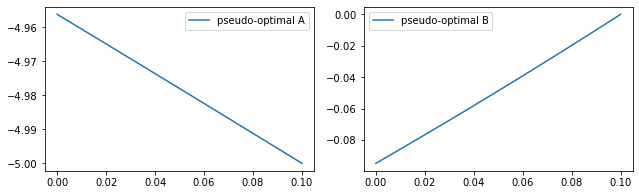

In [8]:
plt.rcParams['figure.figsize'] = (9., 15. / 16 * 3)
nb_t2 = 100
ts2   = np.linspace(0, T, nb_t2)
phisec0  = 2*Z0**1.5 / (kappa**0.5)

Ac,Bc,_,_ = solve_pseudo(eta, phi, alpha, phisec0, gamma, beta, ts2, T)

fig, axes = plt.subplots(1, 2)
axes[0].plot(ts2, Ac); 
axes[1].plot(ts2, Bc); 

axes[0].legend(['pseudo-optimal A'])
axes[1].legend(['pseudo-optimal B'])

plt.tight_layout()
plt.show()

### Numerical scheme

In [9]:
#np.linspace(minS, maxS, 61)

In [10]:
# numerical scheme for A :
# NUMERICAL SCHEME for A
nb_t = 10001
nb_Z = 51
nb_S = 61

minZ, maxZ = 1000, 3000
minS, maxS = 1000, 3000

# minZ, maxZ = 2000,3000
# minS, maxS = 2000,3000

ts = np.linspace(0, T, nb_t)
Zs = np.linspace(minZ, maxZ, nb_Z)
Ss = np.linspace(minS, maxS, nb_S)

Zs_32   = np.array([ii**-1.5 for ii in Zs])
Ss_sqrd = np.array([ii**2 for ii in Ss])
Zs_sqrd = np.array([ii**2 for ii in Zs])

dt = T/nb_t
dZ = (maxZ-minZ)/nb_Z
dS = (maxS-minS)/nb_S

Asol = np.empty((nb_t, nb_Z, nb_S))
Asol[-1,...] = -alpha

Bsol = np.empty((nb_t, nb_Z, nb_S))
Bsol[-1,...] = 0.

Csol = np.empty((nb_t, nb_Z, nb_S))
Csol[-1,...] = 0.

for it in range(nb_t-2,-1,-1):
    if it%100==0: 
        clear_output(wait=True)
        print(' ************ t = ', it)
        todisplay = pd.DataFrame(Asol[it+1, :, :]).round(2)
        todisplay.index = Zs
        todisplay.columns = Ss
        display(todisplay)
        
#     print(' ************ t = ', it)
    
    for iS in range(nb_S):
        S     = Ss[iS]
        Ssqrd = Ss_sqrd[iS]
        
#         if iS == nb_S-1: print(' ***** IS = ', iS)
        if iS == 0:
#            gradASS = 0*(Asol[it+1,:,iS+1] - Asol[it+1,:,iS])/dS**2
            gradASS = (Asol[it+1,:,iS+2] - 2*Asol[it+1,:,iS+1] + Asol[it+1,:,iS])/dS**2
            gradBSS = 0*(Bsol[it+1,:,iS+1] - Bsol[it+1,:,iS])/dS**2
            gradCSS = 0*(Csol[it+1,:,iS+1] - Csol[it+1,:,iS])/dS**2
        elif iS == nb_S-1:
#            gradASS = (- Asol[it+1,:,iS] + Asol[it+1,:,iS-1])/dS**2
            gradASS = (Asol[it+1,:,iS] - 2*Asol[it+1,:,iS-1] + Asol[it+1,:,iS-2])/dS**2
            gradBSS = (- Bsol[it+1,:,iS] + Bsol[it+1,:,iS-1])/dS**2
            gradCSS = (- Csol[it+1,:,iS] + Csol[it+1,:,iS-1])/dS**2
        else:
            gradASS = (Asol[it+1,:,iS+1] - 2*Asol[it+1,:,iS] + Asol[it+1,:,iS-1])/dS**2
            gradBSS = (Bsol[it+1,:,iS+1] - 2*Bsol[it+1,:,iS] + Bsol[it+1,:,iS-1])/dS**2
            gradCSS = (Csol[it+1,:,iS+1] - 2*Csol[it+1,:,iS] + Csol[it+1,:,iS-1])/dS**2
        
#         if iS == nb_S-1: print(gradASS)
        if (gradASS > 1000).any(): print('Error in gradA')
#         if (gradBSS > 100000).any(): print('Error in gradA')
#         if (gradCSS > 100000).any(): print('Error in gradA')
#             print(f't = {it}, S= {Ss[iS]}, Zs foireux = {Zs[np.where(gradASS>100)]}')
#         if np.isnan(gradASS).any():
#             print(f't = {it}, tout foireux')
         
        ##################
        # Solving for A
        ##################        
        # Do some Picard iterations
        picard_term = Asol[it+1,:,iS]
#         if iS == nb_S-1: print('****************************')
        for picard_i in range(2):
            old_picard_term = picard_term
            TriDiag = np.diag(1+(dt/dZ**2)*gamma*gamma*Zs_sqrd + beta*(S-Zs)*dt/dZ - dt*(kappa/eta)*Zs_32*picard_term) + \
                      np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[:-1] - beta*(S-Zs[:-1])*dt/dZ, 1) + \
                      np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[1:], -1)
            cstvec = (phi - 0.5 * sigma * sigma * gradASS * Ssqrd) *  dt 
            
            # border conditions
            TriDiag[0,0]    = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[0] + beta*(S-Zs[0])*dt/dZ - dt*(kappa/eta)*Zs_32[0]*picard_term[0]
            TriDiag[-1,-1]  = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[-1] - dt*(kappa/eta)*Zs_32[-1]*picard_term[-1]
            picard_term = np.linalg.inv(TriDiag) @ (Asol[it+1,:,iS] - cstvec)
            
#             if iS == nb_S-1: print('picard iteration = ', picard_i, 'after :', old_picard_term - picard_term)
            
#             if iS == nb_S-1:              print('after:', picard_term)
# 
        Asol[it,:,iS]  = picard_term

        ##################
        # Solving for B
        ##################
        TriDiag = np.diag(1+(dt/dZ**2)*gamma*gamma*Zs_sqrd + beta*(Ss[iS]-Zs)*dt/dZ - dt*(kappa/eta)*Zs_32*picard_term) + \
                  np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[:-1] - beta*(Ss[iS]-Zs[:-1])*dt/dZ, 1) + \
                  np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[1:], -1)
        cstvec = (-beta*(Ss[iS]-Zs) - 0.5 * sigma * sigma * gradBSS * Ss[iS]**2) *  dt 
        
        # border conditions
        TriDiag[0,0]    = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[0] + beta*(Ss[iS]-Zs[0])*dt/dZ - dt*(kappa/eta)*Zs_32[0]*picard_term[0]
        TriDiag[-1,-1]  = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[-1] - dt*(kappa/eta)*Zs_32[-1]*picard_term[-1]
        Bsol[it,:,iS] = np.linalg.inv(TriDiag) @ (Bsol[it+1,:,iS] - cstvec)
        
        ################## 
        # Solving for C
        ##################
        TriDiag = np.diag(1+(dt/dZ**2)*gamma*gamma*Zs_sqrd + beta*(Ss[iS]-Zs)*dt/dZ) + \
                  np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[:-1] - beta*(Ss[iS]-Zs[:-1])*dt/dZ, 1) + \
                  np.diag(-0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[1:], -1)           
        cstvec = (- 0.25*(kappa/eta)*Zs_32*Bsol[it,:,iS]**2 - 0.5 * sigma * sigma * gradCSS * Ss[iS]**2) *  dt 
        
        # border conditions
        TriDiag[0,0]    = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[0] + beta*(Ss[iS]-Zs[0])*dt/dZ
        TriDiag[-1,-1]  = 1+0.5*(dt/dZ**2)*gamma*gamma*Zs_sqrd[-1]
        Csol[it,:,iS]   = np.linalg.inv(TriDiag) @ (Csol[it+1,:,iS] - cstvec)

 ************ t =  0


,1000.000000,1033.333333,1066.666667,1100.000000,1133.333333,1166.666667,1200.000000,1233.333333,1266.666667,1300.000000,...,2700.000000,2733.333333,2766.666667,2800.000000,2833.333333,2866.666667,2900.000000,2933.333333,2966.666667,3000.000000
1000.0,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04
1040.0,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04
1080.0,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04
1120.0,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04
1160.0,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04
1200.0,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05
1240.0,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05
1280.0,-0.04,-0.04,-0.04,-0.04,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05
1320.0,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05
1360.0,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05


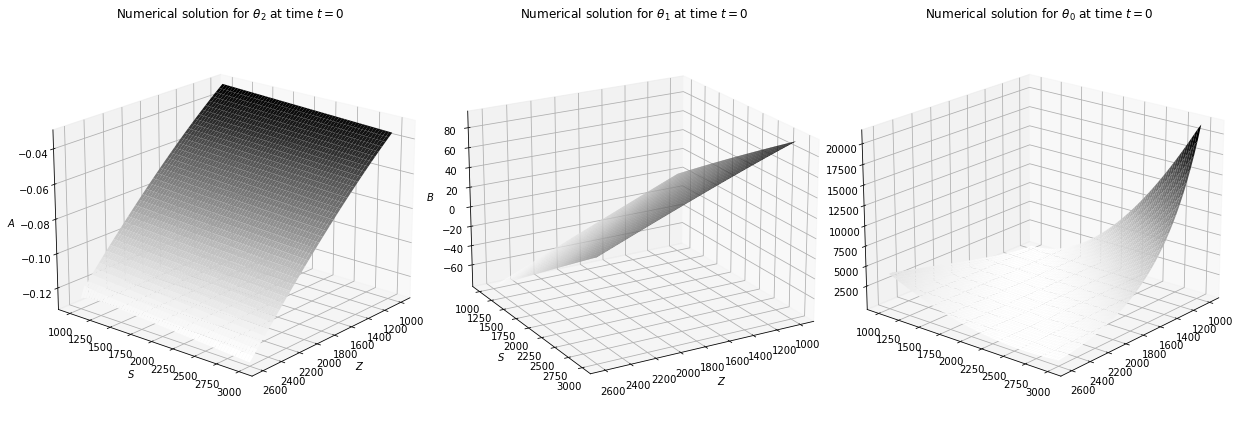

In [11]:
plt.rcParams['figure.figsize'] = (17., 15./16*15)
fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.view_init(elev=20, azim=40)
ax2.view_init(elev=20, azim=60)
ax3.view_init(elev=20, azim=40)

izFrom, izLast = 0, -10
Zs_, Ss_ = np.meshgrid(Zs[izFrom:izLast], Ss, indexing='ij')

surf1 = ax1.plot_surface(Zs_, Ss_, Asol[0,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True) #
surf2 = ax2.plot_surface(Zs_, Ss_, Bsol[0,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True) #
surf3 = ax3.plot_surface(Zs_, Ss_, Csol[0,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True) #

ax1.set_title(r'Numerical solution for $\theta_2$ at time $t=0$')
ax2.set_title(r'Numerical solution for $\theta_1$ at time $t=0$')
ax3.set_title(r'Numerical solution for $\theta_0$ at time $t=0$')

ax1.set_xlabel('$Z$'); ax2.set_xlabel('$Z$') #; ax3.set_xlabel('$y$')
ax1.set_ylabel('$S$');   ax2.set_ylabel('$S$')#;   ax3.set_ylabel('$S$'); 
ax1.set_zlabel(r'$A$'); ax2.set_zlabel(r'$B$') #; ax3.set_zlabel(r'$C$'); 

# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)

plt.tight_layout()

In [27]:
nb_y = 6
minY = -100
maxY = 100
ys = np.linspace(minY, maxY, nb_y)
ys =[-100, 0, 100]

In [28]:
ys

[-100, 0, 100]

In [29]:
def solve_pseudo(eta, phi,  alpha, phisec, gamma, beta, ts, T):
    At = lambda t, s: phi - (1/(phisec*eta))*s**2
    sol = solve_ivp(At, [T, 0], [-alpha], t_eval=ts[::-1])
    A = sol.y[0]
    A_interp = scipy.interpolate.interp1d(ts, A[::-1])
    
    Bt = lambda t, s:  beta + beta*s - (1 / (phisec*eta))*s*A_interp(t)
    sol = solve_ivp(Bt, [T, 0], [0], t_eval=ts[::-1])
    B = sol.y[0]
    B_interp = scipy.interpolate.interp1d(ts, B[::-1])
    
    return A[::-1], B[::-1], A_interp, B_interp

In [33]:
ys

[-100, 0, 100]

In [30]:
v1      = np.empty((nb_y, len(Zs), len(Ss)))
v2      = np.empty((nb_y, len(Zs), len(Ss)))

alldims = nb_y * len(Zs) * len(Ss)
_i = 0

for (iy, ytilde) in enumerate(ys):
    for (iZ, Z) in enumerate(Zs):
        for (iS, S) in enumerate(Ss):
            _i += 1
            
            phisec       = Z**1.5 / kappa # should be changed to real kappa
            # true speed
            v2[iy, iZ, iS]   = -(0.5 * kappa / eta) * (Z**-1.5) * ( 2 * Asol[0, iZ, iS] * ytilde + Bsol[0, iZ, iS])
            
            # approximated speed
            A, B, A_interp, B_interp = solve_pseudo(eta, phi, alpha, phisec, gamma, beta, ts2, T)
            v1[iy, iZ, iS]   = - A[0] * ytilde / (eta * phisec) + 0.5 * B[0] * (S - Z) / (eta * phisec)
            
            if _i%50==0:
                clear_output(wait=True)
                print("progression: ", round(100*_i/alldims, 2), '%')
                print('ytilde =', ytilde, ', Z=', Z, ', S=', S)
                print('true   speed =', v2[iy, iZ, iS])
                print('approx speed =', v1[iy, iZ, iS])
                print('\n')
                print('true   A =', -( kappa / eta) * (Z**-1.5) * Asol[0, iZ, iS]* ytilde)
                print('approx A =', - A[0] * ytilde / (eta * phisec))
                print('\n')
                print('true   B =', -(0.5 * kappa / eta) * (Z**-1.5) *Bsol[0, iZ, iS])
                print('approx B =',  0.5 * B[0] * (S - Z) / (eta * phisec))

progression:  49.82 %
ytilde = 100 , Z= 3000.0 , S= 1900.0
true   speed = 2688.5951163571963
approx speed = 2637.5092495948156


true   A = 965.5400437386153
approx A = 970.1974953779036


true   B = 1723.0550726185807
approx B = 1667.3117542169123


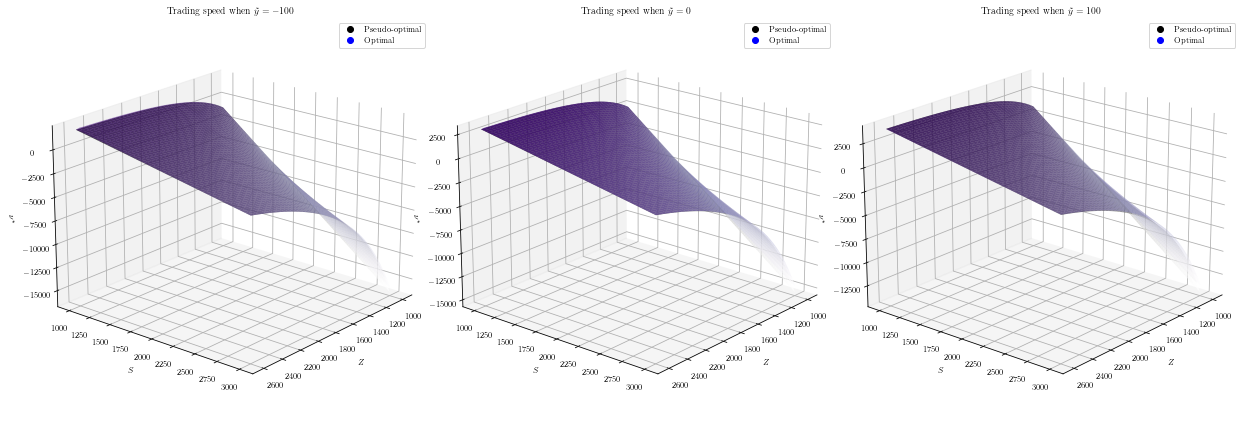

In [34]:
plt.rcParams['figure.figsize'] = (17., 15./16*15)
fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.view_init(elev=20, azim=40)
ax2.view_init(elev=20, azim=40)
ax3.view_init(elev=20, azim=40)

Zs_, Ss_ = np.meshgrid(Zs[izFrom:izLast], Ss, indexing='ij')

iy0, iy1, iy2 = 0, 1, 2

surf1 = ax1.plot_surface(Zs_, Ss_, v1[iy0,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.7 ,label='Pseudo-optimal') #
surf2 = ax2.plot_surface(Zs_, Ss_, v1[iy1,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.7 ,label='Pseudo-optimal') #
surf3 = ax3.plot_surface(Zs_, Ss_, v1[iy2,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.7 ,label='Pseudo-optimal') #

surf1_ = ax1.plot_surface(Zs_, Ss_, v2[iy0,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Purples', linewidth=0, antialiased=True, alpha=0.5 ,label='Optimal') #
surf2_ = ax2.plot_surface(Zs_, Ss_, v2[iy1,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Purples', linewidth=0, antialiased=True, alpha=0.7 ,label='Optimal') #
surf3_ = ax3.plot_surface(Zs_, Ss_, v2[iy2,izFrom:izLast,:], cstride=1, rstride = 1, cmap='Purples', linewidth=0, antialiased=True, alpha=0.5 ,label='Optimal') #

fake2Dline = lines.Line2D([0],[0], linestyle="none", c='k', marker = 'o')
fake2Dline2 = lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')

ax1.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy0], 2)}$')
ax2.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy1], 2)}$')
ax3.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy2], 2)}$')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$Z$'); 
    ax.set_ylabel('$S$');  
    ax.set_zlabel(r'$\nu^\star$'); 
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.legend([fake2Dline, fake2Dline2], ['Pseudo-optimal', 'Optimal'], numpoints = 1)

    
# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)

plt.tight_layout()

In [16]:
Ss[-16]

2500.0

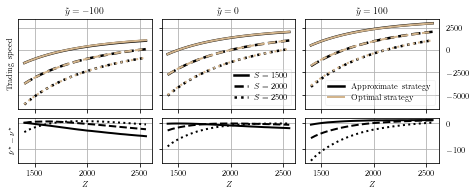

In [38]:
W = 6.5

plt.rcParams.update({
    'figure.figsize': (W, W/(10/4)),     # 4:3 aspect ratio
    'font.size' : 8,                   # Set font size to 11pt
    'axes.labelsize': 8,               # -> axis labels
    'legend.fontsize': 8,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

fig, axes = plt.subplots(2, 3, constrained_layout=True, sharey=False, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

iy0, iy1, iy2 = 0, 1, 2
iS0, iS1, iS2 = 15, int(len(Ss)/2), -16
iZfrom, iZto = 10, -11

axes[0,1].sharey(axes[0,0])
axes[0,2].sharey(axes[0,0])

axes[1,1].sharey(axes[1,0])
axes[1,2].sharey(axes[1,0])

for (ax, iy) in zip(axes[0,2:], (iy2,)):
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS0], color='k', linewidth=2.5, linestyle='solid')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS0], color='tan', linewidth=2, linestyle='solid')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS1], color='k', linewidth=2.5, linestyle='dashed', label='_nolegend_')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS1], color='tan', linewidth=2, linestyle='dashed', label='_nolegend_')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS2], color='k', linewidth=2.5, linestyle='dotted', label='_nolegend_')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS2], color='tan', linewidth=2, linestyle='dotted', label='_nolegend_')    
    ax.set_title(r'$ \quad \tilde{y}' + f' = {round(ys[iy])}$')
    ax.grid()
for (ax, iy) in zip( axes[0,:2], (iy0,iy1)):
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS0], color='k', linewidth=2.5, linestyle='solid')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS0], color='tan', linewidth=2, linestyle='solid', label='_nolegend_')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS1], color='k', linewidth=2.5, linestyle='dashed')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS1], color='tan', linewidth=2, linestyle='dashed', label='_nolegend_')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS2], color='k', linewidth=2.5, linestyle='dotted')
    ax.plot(Zs[iZfrom:iZto], v2[iy,iZfrom:iZto,iS2], color='tan', linewidth=2, linestyle='dotted', label='_nolegend_')    
    ax.set_title(r'$ \quad \tilde{y}' + f' = {round(ys[iy])}$')
    ax.grid()
    
for (ax, iy) in zip(axes[1,:], (iy0, iy1, iy2)):
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS0]-v2[iy,iZfrom:iZto,iS0], color='k', linewidth=2, linestyle='solid')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS1]-v2[iy,iZfrom:iZto,iS1], color='k', linewidth=2, linestyle='dashed')
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS2]-v2[iy,iZfrom:iZto,iS2], color='k', linewidth=2, linestyle='dotted')
    ax.set_xlabel('$Z$')
    
    ax.grid()
    
axes[0,0].set_ylabel(r'Trading speed')
axes[1,0].set_ylabel(r'$\tilde{\nu}^{\star} - \nu^{\star}$')
axes[0,-1].legend([f'Approximate strategy', 
                    f'Optimal strategy'], ncol=1, handlelength=2, framealpha=0.2, loc='best')
axes[0,-2].legend([f'$S  = {round(Ss[iS0])}$', 
                    f'$S  = {round(Ss[iS1])}$', 
                    f'$S  = {round(Ss[iS2])}$',
                    ], ncol=1, handlelength=1.8, framealpha=0.2, loc='best')
#axes[1,-2].legend([f' $S  = {round(Ss[iS0])}$', 
#                    f'$S  = {round(Ss[iS1])}$', 
#                    f'$S  = {round(Ss[iS2])}$'
#                    ], ncol=1, handlelength=1.8, framealpha=0.2, loc='best')

axes[0,0].tick_params("y", left=False,  labelleft  = False)
axes[0,1].tick_params("y", right=False, labelright = False, labelleft=False)
axes[0,2].tick_params("y", right=False, labelright = True, labelleft=False)

axes[1,0].tick_params("y", left=False, labelleft   = False)
axes[1,1].tick_params("y", right=False, labelright = False, labelleft=False)
axes[1,2].tick_params("y", right=False, labelright = True, labelleft=False)

# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)
plt.savefig('comparisonnumerical2.pdf', bbox_inches='tight')
plt.show()

In [449]:
Ss

array([1000., 1040., 1080., 1120., 1160., 1200., 1240., 1280., 1320.,
       1360., 1400., 1440., 1480., 1520., 1560., 1600., 1640., 1680.,
       1720., 1760., 1800., 1840., 1880., 1920., 1960., 2000., 2040.,
       2080., 2120., 2160., 2200., 2240., 2280., 2320., 2360., 2400.,
       2440., 2480., 2520., 2560., 2600., 2640., 2680., 2720., 2760.,
       2800., 2840., 2880., 2920., 2960., 3000.])

In [ ]:
W = 7

plt.rcParams.update({
    'figure.figsize': (W, W/(10/4)),     # 4:3 aspect ratio
    'font.size' : 8,                   # Set font size to 11pt
    'axes.labelsize': 8,               # -> axis labels
    'legend.fontsize': 8,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

fig, axes = plt.subplots(1, 3, constrained_layout=True, sharey=True, sharex=True)

iy0, iy1, iy2 = 6, int(len(ys)/2), -7
iS0, iS1, iS2 = 15, int(len(Ss)/2), -16
iZfrom, iZto = 20, -6

for (ax, iy) in zip(axes, (iy0, iy1, iy2)):
    ax.plot(Zs[iZfrom:iZto], v1[iy,iZfrom:iZto,iS0]-v2[iy,iZfrom:iZto,iS0], 
                color='k', linewidth=2, linestyle='solid')

   
    ax.set_title(r'$ \quad \tilde{y}' + f' = {round(ys[iy], 2)}$')

    ax.set_xlabel('$Z$')
axes[0].set_ylabel(r'$\nu$')
axes[-1].legend( [f'Approx:  \  $S  = {round(Ss[iS0], 0)}$', 
                    f'Optimal: $S  = {round(Ss[iS0], 0)}$', 
                    f'Approx:  \  $S  = {round(Ss[iS1], 0)}$', 
                    f'Optimal: $S  = {round(Ss[iS1], 0)}$', 
                    f'Approx:  \  $S  = {round(Ss[iS2], 0)}$', 
                    f'Optimal: $S  = {round(Ss[iS2], 0)}$', 
                    ], ncol=1, handlelength=2, framealpha=0.2, loc='best')
    
# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)
plt.savefig('comparisonnumerical.pdf', bbox_inches='tight')
plt.show()

In [215]:
iZ1 = 20
iZ2 = -20

In [216]:
Zs[iZ1:iZ2]

array([1800., 1840., 1880., 1920., 1960., 2000., 2040., 2080., 2120.,
       2160., 2200.])

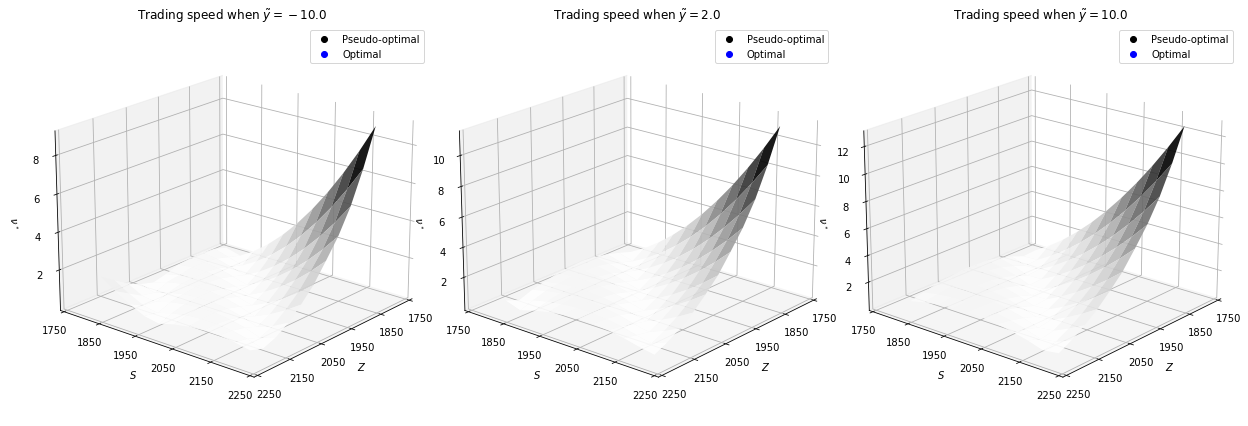

In [244]:
plt.rcParams['figure.figsize'] = (17., 15./16*15)
fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.view_init(elev=20, azim=40)
ax2.view_init(elev=20, azim=40)
ax3.view_init(elev=20, azim=40)

Zs_, Ss_ = np.meshgrid(Zs[iZ1:iZ2], Ss[iZ1:iZ2], indexing='ij')

iy0, iy1, iy2 = 0, int(len(ys)/2), -1

surf1 = ax1.plot_surface(Zs_, Ss_, np.abs((v1[iy0,iZ1:iZ2,iZ1:iZ2]- v2[iy0,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #
surf2 = ax2.plot_surface(Zs_, Ss_, np.abs((v1[iy1,iZ1:iZ2,iZ1:iZ2]- v2[iy1,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #
surf3 = ax3.plot_surface(Zs_, Ss_, np.abs((v1[iy2,iZ1:iZ2,iZ1:iZ2]- v2[iy2,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #

fake2Dline = lines.Line2D([0],[0], linestyle="none", c='k', marker = 'o')
fake2Dline2 = lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')

ax1.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy0], 2)}$')
ax2.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy1], 2)}$')
ax3.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy2], 2)}$')

#ax2.set_zlim3d(ax1.get_zlim3d())
#ax3.set_zlim3d(ax1.get_zlim3d())


for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$Z$'); 
    ax.set_ylabel('$S$');  
    ax.set_zlabel(r'$\nu^\star$'); 
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.legend([fake2Dline, fake2Dline2], ['Pseudo-optimal', 'Optimal'], numpoints = 1)

ax1.set_xticks(ax1.get_xticks()[::-2])
ax2.set_xticks(ax2.get_xticks()[::-2])
ax3.set_xticks(ax3.get_xticks()[::-2])

ax1.set_yticks(ax1.get_yticks()[::-2])
ax2.set_yticks(ax2.get_yticks()[::-2])
ax3.set_yticks(ax3.get_yticks()[::-2])
    
# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)

plt.tight_layout()

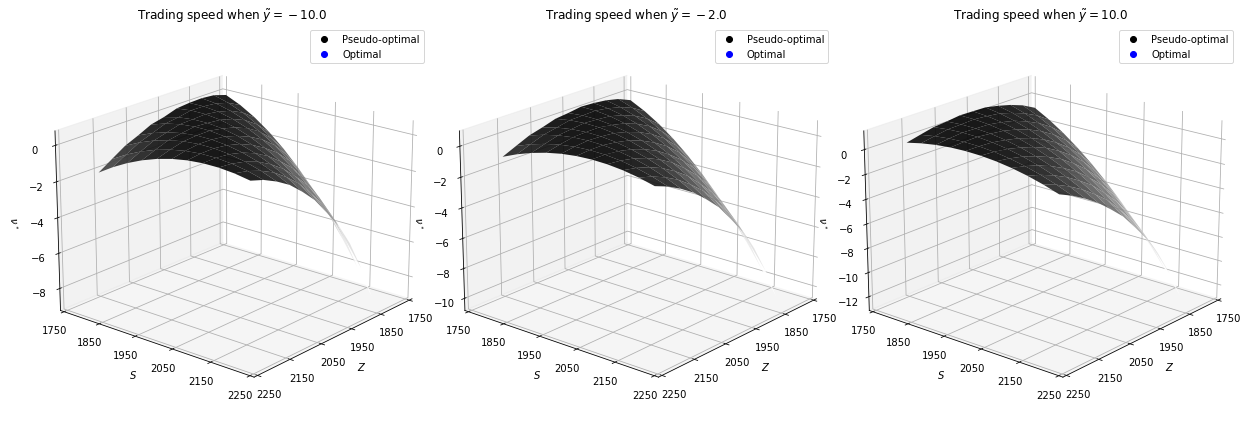

In [246]:
plt.rcParams['figure.figsize'] = (17., 15./16*15)
fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.view_init(elev=20, azim=40)
ax2.view_init(elev=20, azim=40)
ax3.view_init(elev=20, azim=40)

Zs_, Ss_ = np.meshgrid(Zs[iZ1:iZ2], Ss[iZ1:iZ2], indexing='ij')

iy0, iy1, iy2 = 0, int(len(ys)/2)-1, -1

surf1 = ax1.plot_surface(Zs_, Ss_, ((v1[iy0,iZ1:iZ2,iZ1:iZ2]- v2[iy0,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #
surf2 = ax2.plot_surface(Zs_, Ss_, ((v1[iy1,iZ1:iZ2,iZ1:iZ2]- v2[iy1,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #
surf3 = ax3.plot_surface(Zs_, Ss_, ((v1[iy2,iZ1:iZ2,iZ1:iZ2]- v2[iy2,iZ1:iZ2,iZ1:iZ2])), cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True, alpha=0.9 ,label='Pseudo-optimal') #

fake2Dline  = lines.Line2D([0],[0], linestyle="none", c='k', marker = 'o')
fake2Dline2 = lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')

ax1.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy0], 2)}$')
ax2.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy1], 2)}$')
ax3.set_title(f'Trading speed when ' + r'$\tilde{y}' + f' = {round(ys[iy2], 2)}$')

#ax2.set_zlim3d(ax1.get_zlim3d())
#ax3.set_zlim3d(ax1.get_zlim3d())


for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$Z$'); 
    ax.set_ylabel('$S$');  
    ax.set_zlabel(r'$\nu^\star$'); 
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.legend([fake2Dline, fake2Dline2], ['Pseudo-optimal', 'Optimal'], numpoints = 1)

ax1.set_xticks(ax1.get_xticks()[::-2])
ax2.set_xticks(ax2.get_xticks()[::-2])
ax3.set_xticks(ax3.get_xticks()[::-2])

ax1.set_yticks(ax1.get_yticks()[::-2])
ax2.set_yticks(ax2.get_yticks()[::-2])
ax3.set_yticks(ax3.get_yticks()[::-2])

# fig.colorbar(surf1, shrink=0.5, aspect=5)
# fig.colorbar(surf2, shrink=0.5, aspect=5)

plt.tight_layout()